In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
class simulation:
    def __init__(self, file):
        self.d = np.genfromtxt(file)
    #     gal_id = d[:,0]
        self.zt = self.d[:,1]
        self.zph= self.d[:,2]
    #     zph_err = d[:,3]
        self.Ngal = self.zt.size
        
    def plot_scatter(self, fig_file=None):
        plt.figure(figsize=(8,8))
        plt.scatter(self.zt, self.zph, s=0.05, c='red')
        plt.xlim(0,3.5)
        plt.ylim(0,3.5)
        plt.xlabel(r'$z_{\rm true}$')
        plt.ylabel(r'$z_{\rm ph}$')
        if fig_file is not None:
            plt.savefig(fig_file)
        plt.show()
    
    def get_stochastic_mat(self, mat_file=None):
        dz = 0.05
        self.dz = dz
        zmax = 3.5
        zt_delims = np.arange(0.0, zmax, dz)
        Nt = zt_delims.size
        self.Nt = Nt
        print('zbins:', zt_delims, Nt)

        mat = np.int_(np.zeros((Nt,Nt))) # Ngal mixture matrix
        mat_norm = np.zeros((Nt,Nt)) # Ngal mixture matrix
        Nx = np.int_(np.zeros(Nt)) # Ngal in each z_true bin
        ix = np.int_(np.floor(self.zt/dz))
        iy = np.int_(np.floor(self.zph/dz))
        ix[ix>Nt]=Nt # gals with z>3.45 are all assigned into Nt-th bin
        iy[iy>Nt]=Nt
        for i in range(self.Ngal):
            Nx[ix[i]] += 1
            mat[ix[i]][iy[i]] += 1

        print("bin index of each z_true: ix:", ix)
        print('Ngal in each z_true bin: Nx =', Nx)
        print('Unnormalized matrix:', mat)

        for i in range(Nt):
            mat_norm[i] = mat[i]/float(Nx[i])
        print('Stochastic matrix:', mat_norm)

        if mat_file is not None:
            np.savetxt(mat_file, mat_norm)
            print('matrix saved.')
        return mat_norm
    
    def plot_mat_norm(self, mat_norm, fig_file=None):
        fig,ax=plt.subplots(1,1,figsize=(10,10))
        img = ax.imshow(mat_norm.T, origin='lower')
        ticks = np.arange(-0.5,self.Nt,10)
        ticklabels = ["{:6.1f}".format(i) for i in self.dz*(ticks+0.5)]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticklabels)
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticklabels)
        ax.set_xlabel(r'$z_{\rm true}$')
        ax.set_ylabel(r'$z_{\rm ph}$')
        fig.colorbar(img)
        if fig_file is not None:
            plt.savefig(fig_file)
            print('figure saved.')
        plt.show()
    
    def convert_nz(self, matnorm, toconvert_files):
        for toconvert_file1 in toconvert_files:
            d1 = np.loadtxt(toconvert_file1)
            z = d1[:,1]
            nz_old = d1[:,3]
            ix_z = np.int_(np.floor(z/self.dz))
            prefactor = np.int_(np.zeros(self.Nt))
            for i in range(z.size):
                prefactor[ix_z[i]] += 1

            nz_new = np.zeros(z.size)
            for i in range(z.size):
                for j in range(z.size):
                    nz_new[i] += mat_norm[ix_z[j]][ix_z[i]] * nz_old[j]
                nz_new[i] /= prefactor[ix_z[i]]

            np.savetxt(toconvert_file1+'new', np.c_[d1[:,0],d1[:,1],d1[:,2],nz_new])
            print('new nz saved.')
            plt.plot(z, nz_old, '--')
            plt.plot(z, nz_new)
            plt.xlabel(r'$z$')
            plt.ylabel(r'$n(z)$')
            plt.show()

In [4]:
simfile = 'Graham20/LSSTyear2_noEuclid.zphot'
mat_file = simfile[:-6]+'_mat.txt'
toconvert_files = ['../zdistris/lens_LSSTY1', '../zdistris/src_LSSTY1']

In [5]:
simY2 = simulation(simfile)

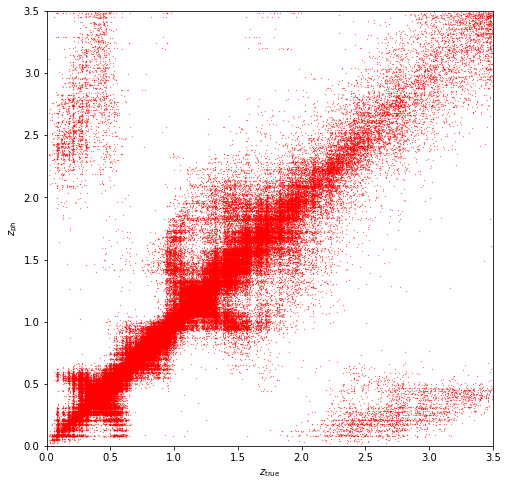

In [6]:
simY2.plot_scatter()

In [7]:
mat_norm = simY2.get_stochastic_mat(mat_file=mat_file)

zbins: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05
 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75
 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35 3.4  3.45] 70
bin index of each z_true: ix: [31  7 20 ... 19 59 44]
Ngal in each z_true bin: Nx = [  74 1231  960 1505 3731 5961 5014 4056 6415 8425 7147 8073 9834 6406
 6167 7735 7292 4950 6383 7005 4818 4180 3839 3279 3416 3766 3767 2390
 3857 3146 2296 2726 1354 2240 1964 1128 1642 1184 1279 1189  796  825
  675  549  838  624  563  567  624  520  490  334  410  419  450  479
  297  231  317  295  324  221  245  266  190  224  230  233  201  276]
Unnormalized matrix: [[ 14  31   1 ...   0   0   0]
 [ 25 690 126 ...   0   0   5]
 [  4 148 282 ...   0   0   3]
 ...
 [  0   0   0 ...  21  34  27]
 [  0   0   0 ...  22  21  25]
 [  0   0   0

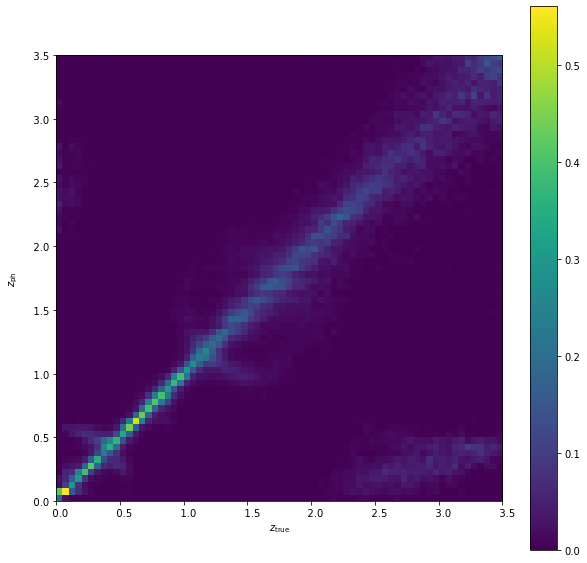

In [8]:
simY2.plot_mat_norm(mat_norm)

new nz saved.


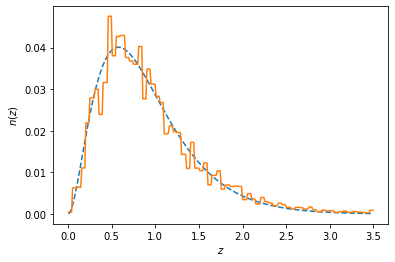

new nz saved.


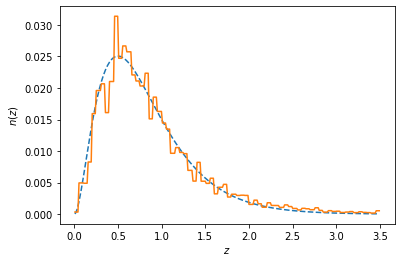

In [9]:
simY2.convert_nz(mat_norm,toconvert_files)

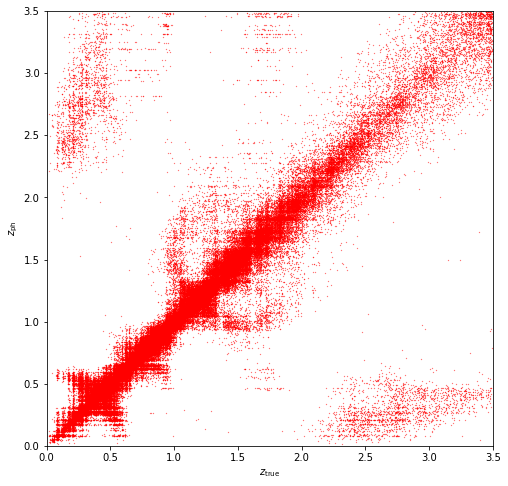

zbins: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05
 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75
 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35 3.4  3.45] 70
bin index of each z_true: ix: [31  7 20 ... 10 19 59]
Ngal in each z_true bin: Nx = [   74  1230   961  1516  3745  5954  5045  4124  6596  8734  7493  8496
 10390  6775  6383  8094  7587  5121  6487  7076  4831  4201  3829  3258
  3386  3755  3759  2375  3844  3126  2282  2699  1332  2218  1941  1111
  1619  1171  1249  1179   798   826   655   546   825   622   550   568
   621   538   482   332   416   427   481   485   322   245   339   344
   371   249   282   313   224   256   270   269   242   324]
Unnormalized matrix: [[ 25  33   2 ...   0   0   0]
 [ 28 870 101 ...   0   0   0]
 [  4 172 371 ...   0   0   0]
 ...
 [  

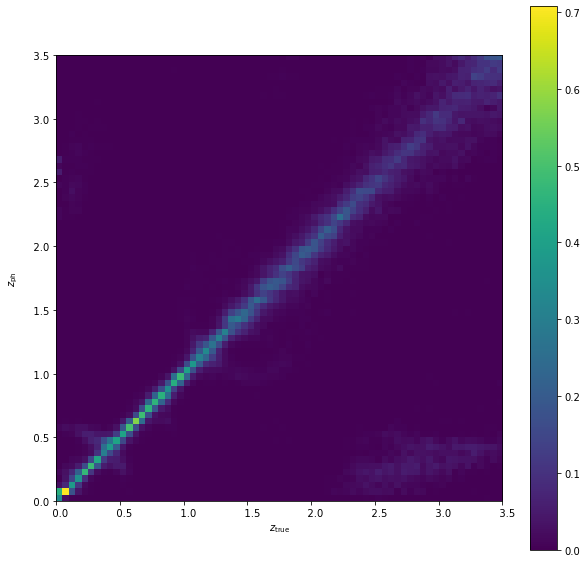

new nz saved.


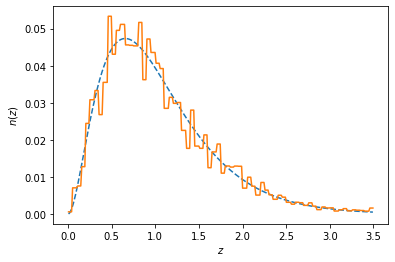

new nz saved.


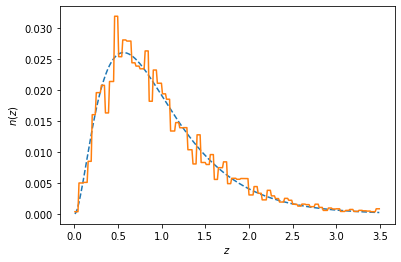

In [10]:
simfile = 'Graham20/LSSTyear5_noEuclid.zphot'
mat_file = simfile[:-6]+'_mat.txt'
toconvert_files = ['../zdistris/lens_LSSTY6', '../zdistris/src_LSSTY6']
simY6 = simulation(simfile)
simY6.plot_scatter()
mat_normY6 = simY6.get_stochastic_mat(mat_file=mat_file)
simY6.plot_mat_norm(mat_normY6)
simY6.convert_nz(mat_normY6,toconvert_files)